
## Imports

In [153]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas
import numpy as np
import time 
import itertools

from sklearn.model_selection import train_test_split
from itertools import zip_longest
from Bio.Seq import translate, IUPAC
from torch.nn import functional as F
from scipy.stats import skewnorm
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Reshape, Softmax
from tensorflow.keras import Model
from keras.datasets import mnist

## Create Synthetic Dataset

In [157]:
def f(x, w, b): 
    return np.dot(x, w)  + b 

def make_weights(length):
    return [np.random.random() * 10 for _ in range(length)], np.random.random() * 10


def one_hot_encode_sequence(iterable, mp): 
    result = []
    for x in iterable: 
        result.extend(mp[x])
    return result

def normalize(y): 
    return (y - y.mean()) / y.std()


M, L = 10, 4
w, b = make_weights(M * L)

## Create Train and Test Set


In [158]:
X = []
cnt = 0
for x in itertools.product(range(L), repeat=M): 
    seq = one_hot_encode_sequence(x, mp)
    X.append(seq)
    cnt += 1;
assert(cnt == L ** M)


In [159]:
X = np.array(X)
y = np.array([f(x, w, b) for x in X])
mean, std = y.mean(), y.std()
y = normalize(y)

NUM_TRAIN, NUM_TEST, EPS = 5000, 1000, 0.1
ADD_NOISE = True
indexes = np.random.choice(L ** M, NUM_TRAIN + NUM_TEST, replace=False)
train_indexes = indexes[:NUM_TRAIN]
test_indexes = indexes[NUM_TRAIN:]


train_X = X[train_indexes]
train_y = y[train_indexes] + np.random.normal(loc=0, scale= eps, size=NUM_TRAIN)
if ADD_NOISE: 
    train_y += np.random.normal(loc=0, scale= eps, size=NUM_TRAIN)
test_X = X[test_indexes]
test_y = y[test_indexes]
if ADD_NOISE: 
    train_y += np.random.normal(loc=0, scale= eps, size=NUM_TRAIN)
print(max(y))

3.5857574623788016


In [162]:
print(X[np.argmax(y)], np.argmax(y))
maximal_sequence = X[np.argmax(y)]


[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.] 120071


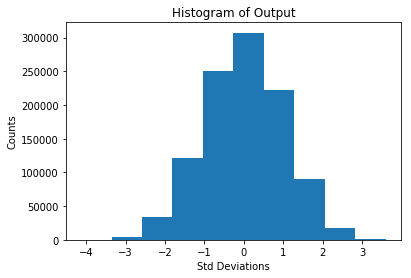

In [163]:
plt.title("Histogram of Output")
plt.xlabel("Std Deviations")
plt.ylabel("Counts")
plt.hist(y)
plt.show()

## Train Softmax Model on Synthetic Dataset 


In [282]:
class MyModel(Model):
    #To Do: add way to make inputs drawn from probability simplex
    def __init__(self, M, L):
        super(MyModel, self).__init__()
        self.reshape = Reshape((-1, M, L), name = 'reshape')
        self.softmax = Softmax(axis=-1, name = 's1')
        self.flatten = Flatten()
        self.d1 = Dense(50, name='d1')
        self.r1 = Activation('relu', name = 'r1')
        self.d2 = Dense(10, name='d2')
        self.r2 = Activation('relu', name = 'r1')
        self.d3 = Dense(1, name='d3')

    def call(self, x):
        x = self.reshape(x)
        x = self.softmax(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.r1(x)
        x = self.d2(x)
        x = self.r2(x)
        return self.d3(x)
        
# define own function
def train_step(model, inputs, outputs):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_object(outputs, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    
def test_step(model, inputs, outputs):
    predictions = model(inputs)
    t_loss = loss_object(outputs, predictions)
    test_loss(t_loss)
    
def train(model, train_ds, test_ds, EPOCHS=1, verbose=True):
    train_losses, test_losses = [], []
    for epoch in range(EPOCHS):
        for inputs, outputs in train_ds:
            train_step(model, inputs, outputs)

        for inputs, outputs in test_ds:
            test_step(model, inputs, outputs)
        
        template = 'Epoch {}, Loss: {}, Test Loss: {}'
        if verbose: print(template.format(epoch+1,
                            train_loss.result().numpy(),
                            test_loss.result().numpy()))
        # Reset the metrics for the next epoch
        train_losses.append(train_loss.result().numpy());
        test_losses.append(test_loss.result().numpy())
        train_loss.reset_states()
        test_loss.reset_states()
    return train_losses, test_losses 
            
model = MyModel(M, L)
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')


In [207]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
EPOCHS = 10
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(BATCH_SIZE)

In [208]:
train(model, train_dataset, test_dataset, EPOCHS)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.9068201780319214, Test Loss: 0.8422864675521851
Epoch 2, Loss: 0.6953238844871521, Test Loss: 0.6152029037475586
Epoch 3, Loss: 0.4642467200756073, Test Loss: 0.34766557812690735
Epoch 4, Loss: 0.21574196219444275, Test Loss: 0.12537118792533875
Epoch 5, Loss: 0.06416255980730057, Test Loss: 0.03000437095761299
Epoch 6, Loss: 0.014544754289090633, Test Loss: 0.0069631533697247505
Epoch 7, Loss: 0.004459992051124573, Test Loss: 0.0029850893188267946
Epoch 8, Loss: 0.0026257536374032497, 

## Run AM on the model to find best sequence and value. 

In [251]:
def count_substring_mismatch(s1, s2):
    """
    :param s1: string one
    :param s2: string two
    :return: int of the number of mismatches between the two sequences
    >>> count_substring_mismatch('1', '2')
    1
    >>> count_substring_mismatch('ACT', 'ACGA')
    2
    """
    return sum([i != j for i, j in zip_longest(s1, s2)])

def convert_simplex_to_sequence(tensor, return_probs=False, return_argmax=False, return_dna=False): 
    assert return_probs + return_argmax + return_dna == 1
    dna_mp = {
        0 : "A", 
        1 : "C", 
        2 : "T", 
        3 : "G"
    }
    probs = tf.reshape(tensor, (-1, 4)).numpy()
    if return_probs: 
        return probs
    argmax_lst = np.argmax(probs, axis = -1)
    if return_argmax: 
        return argmax_lst
    dna = "".join([dna_mp[i] for i in argmax_lst])
    if return_dna:
        return dna
    
def gradient_ascent(model, input_tensor, M, L, mp, maximal_sequence, iterations = 100, lr=0.1, clip=False):
    softmax_model = tf.keras.Sequential([model.layers[0], model.layers[1], model.layers[2]])
    am_input = tf.Variable(tf.cast(tf.convert_to_tensor([input_tensor]), tf.float32), trainable=True)
    learning_rate = tf.constant(lr)
    loss = model(am_input)
    loss_lst, prob_lst, argmax_lst, sequence_lst, hamming_lst, grad_lst = [], [], [], [], [], []
    for i in range(iterations):
        prob_tensor = softmax_model(am_input)
        np.testing.assert_almost_equal([[1.0] * M], tf.reduce_sum(tf.reshape(softmax_model(am_input), (-1, M, L)), axis = -1).numpy(), decimal=3)
        probs = convert_simplex_to_sequence(prob_tensor, return_probs=True)
        argmax = convert_simplex_to_sequence(prob_tensor, return_argmax=True)
        sequence = one_hot_encode_sequence(argmax, mp)
        hamming_distance = count_substring_mismatch(sequence, maximal_sequence) // 2
        loss_lst.append(loss.numpy()[0][0]); 
        prob_lst.append(probs)
        argmax_lst.append(argmax)
        sequence_lst.append(sequence)
        hamming_lst.append(hamming_distance)
        with tf.GradientTape() as tape:
            loss = model(am_input)
        am_gradient = tape.gradient(loss, am_input) 
        grad_lst.append(am_gradient)
        am_input.assign_add(learning_rate * am_gradient)
        if clip: 
            am_input = tf.Variable(tf.clip_by_value(am_input, 0, 1), trainable=True) 
    return loss_lst, prob_lst, argmax_lst, sequence_lst, hamming_lst, grad_lst


In [210]:
output_lst, prob_lst, argmax_lst, sequence_lst, hamming_lst, grad_lst = gradient_ascent(model, tf.random.normal((1, M * L)), M, L, mp, maximal_sequence, lr = 3.0)

In [211]:
print(model(tf.reshape(tf.convert_to_tensor(prob_lst[-1]), (1, M * L))).numpy()[0][0])
print(model(tf.reshape(tf.convert_to_tensor(maximal_sequence), (1, M * L))).numpy()[0][0])
print((f(prob_lst[-1].flatten(), w, b) - mean) / std)
print((f(maximal_sequence.flatten(), w, b) - mean) / std)
print(max(y))

3.1385846
3.1391513
3.4277717800008163
3.5857574623788016
3.5857574623788016


## Train Softmax Model with Temperature 

In [274]:
class TemperatureModel(Model):
    #To Do: add way to make inputs drawn from probability simplex
    def __init__(self, M, L, beta = 1.0):
        super(TemperatureModel, self).__init__()
        self.reshape = Reshape((-1, M, L), name = 'reshape')
        self.softmax = Softmax(axis=-1, name = 's1')
        self.beta = beta
        self.flatten = Flatten()
        self.d1 = Dense(50, name='d1')
        self.r1 = Activation('relu', name = 'r1')
        self.d2 = Dense(10, name='d2')
        self.r2 = Activation('relu', name = 'r1')
        self.d3 = Dense(1, name='d3')

    def call(self, x):
        x = self.reshape(x)
        x = x * self.beta
        x = self.softmax(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.r1(x)
        x = self.d2(x)
        x = self.r2(x)
        return self.d3(x)
        

            
model = TemperatureModel(M, L, beta = 3.0)
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
EPOCHS = 10
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(BATCH_SIZE)
train(model, train_dataset, test_dataset, EPOCHS)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.9755030870437622, Test Loss: 0.8337095379829407
Epoch 2, Loss: 0.6556573510169983, Test Loss: 0.459869921207428
Epoch 3, Loss: 0.27722665667533875, Test Loss: 0.12028718739748001
Epoch 4, Loss: 0.06873199343681335, Test Loss: 0.035338327288627625
Epoch 5, Loss: 0.033252183347940445, Test Loss: 0.025741249322891235
Epoch 6, Loss: 0.02679452672600746, Test Loss: 0.021337276324629784
Epoch 7, Loss: 0.02222282439470291, Test Loss: 0.017782192677259445
Epoch 8, Loss: 0.018725739791989326, Te

## Run AM on the model to find best sequence and value. 

In [275]:
output_lst, prob_lst, argmax_lst, sequence_lst, hamming_lst, grad_lst = gradient_ascent(model, tf.random.normal((1, M * L)), M, L, mp, maximal_sequence, lr = 0.01)
                            

In [278]:
print(hamming_lst)
print(grad_lst)
print(output_lst)
print(prob_lst[-1], prob_lst[-2])

[6, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[<tf.Tensor: id=6142922, shape=(1, 1, 40), dtype=float32, numpy=
array([[[ 9.8176199e-01,  1.4456305e-02, -1.5550680e-01, -8.4071147e-01,
         -1.5649712e-02,  8.1534557e-02, -6.5442130e-02, -4.4282409e-04,
         -1.0698728e-01, -2.4924123e-01,  1.3761974e-03,  3.5485229e-01,
          1.2454284e-02,  2.3435403e-03,  1.4766033e-02, -2.9563811e-02,
          5.7096891e-02,  1.0183327e-02, -6.8442397e-02,  1.1621882e-03,
         -4.1986321e-05,  7.3003946e-03, -2.1475353e-03, -5.1108487e-03,
          3.8048202e-01, -1.8066235e-01, -2.6676413e-01,  6.6944391e-02,
          1.2527469e-01, -1.0054956e-01, -2.6163079e-02,  1.4378654e-03,
         -6.3465871e-03,  1.9551991e-02, -2.801129

In [277]:
print(model(tf.reshape(tf.convert_to_tensor(prob_lst[-1]), (1, M * L))).numpy()[0][0])
print(model(tf.reshape(tf.convert_to_tensor(maximal_sequence), (1, M * L))).numpy()[0][0])
print((f(prob_lst[-1].flatten(), w, b) - mean) / std)
print((f(maximal_sequence.flatten(), w, b) - mean) / std)
print(max(y))

1.1123054
2.7468767
0.9270305838055126
3.5857574623788016
3.5857574623788016


## Plot Global max differences 

In [284]:
beta_lst = [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0]
learning_rate_lst = [0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0]
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
EPOCHS = 10
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(BATCH_SIZE)
all_test_losses, all_output, all_prob, all_argmax, all_sequence, all_hamming, all_grad, all_lr  = [], [], [], [], [], [], [], []
seq = tf.random.normal((1, M * L))
for beta in beta_lst: 
    model = TemperatureModel(M, L, beta = beta)
    loss_object = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    test_loss = tf.keras.metrics.Mean(name='test_loss')
    _, test_losses = train(model, train_dataset, test_dataset, EPOCHS, verbose=False)
    mx_result, mx_output, mx_prob, mx_argmax, mx_sequence, mx_hamming, mx_grad, mx_lr = -10, [], [], [], [], [], [], -1
    for lr in learning_rate_lst: 
        output_lst, prob_lst, argmax_lst, sequence_lst, hamming_lst, grad_lst = gradient_ascent(model, seq, M, L, mp, maximal_sequence, lr = lr)
        if mx_result < output_lst[-1]: 
            mx_result = output_lst[-1]
            mx_output, mx_prob, mx_argmax, mx_sequence, mx_hamming, mx_grad = output_lst, prob_lst, argmax_lst, sequence_lst, hamming_lst, grad_lst
            mx_lr = lr 
    all_test_losses.append(test_losses)
    all_output.append(mx_output)
    all_prob.append(mx_prob)
    all_argmax.append(mx_argmax)
    all_sequence.append(mx_sequence)
    all_hamming.append(mx_hamming)
    all_grad.append(mx_grad)
    all_lr.append(mx_lr)
    print("Beta: {}, Test loss: {}, LR: {}, Mx Output: {}, Mx hamming {}".format(beta, test_losses[-1], mx_lr, mx_output[-1], mx_hamming[-1]))
    
        
        


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Beta: 0.01, Test loss: 1.018539547920227, LR: 30.0, Mx Output: 0.012692343443632126, Mx hamming 8

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you 

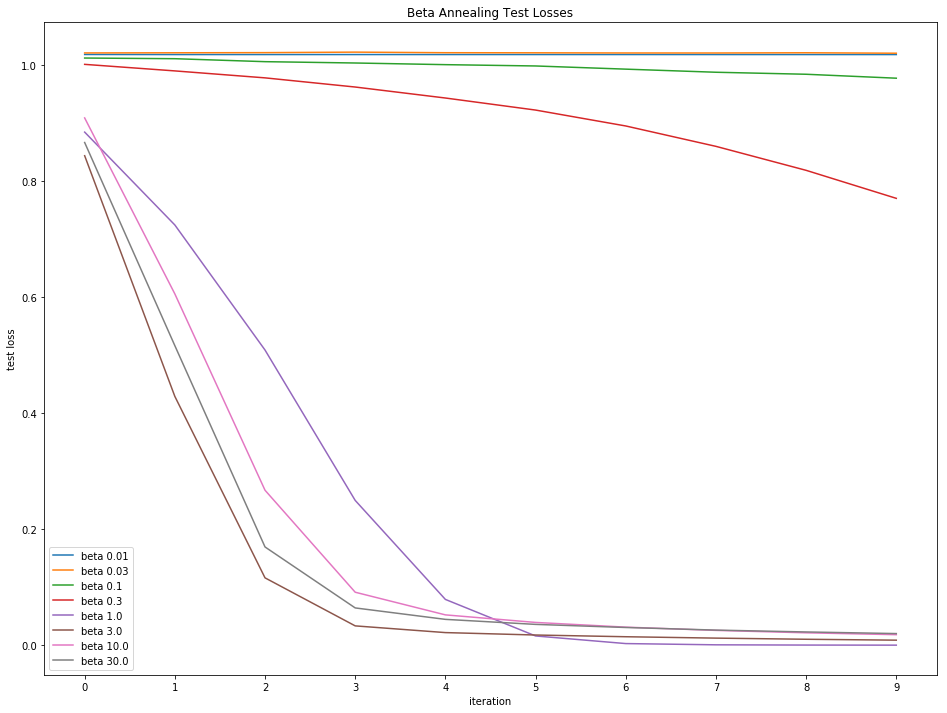

In [288]:
plt.figure(figsize = (16, 12))
for beta, test_losses in zip(beta_lst, all_test_losses): 
    plt.plot(test_losses, label="beta {}".format(beta))
plt.legend()
plt.title("Beta Annealing Test Losses")
plt.xlabel("iteration")
plt.xticks(range(0, 10))
plt.ylabel("test loss")
plt.savefig('../plots/10_15_beta_annealing_test_losses.png')
plt.show()
plt.close()

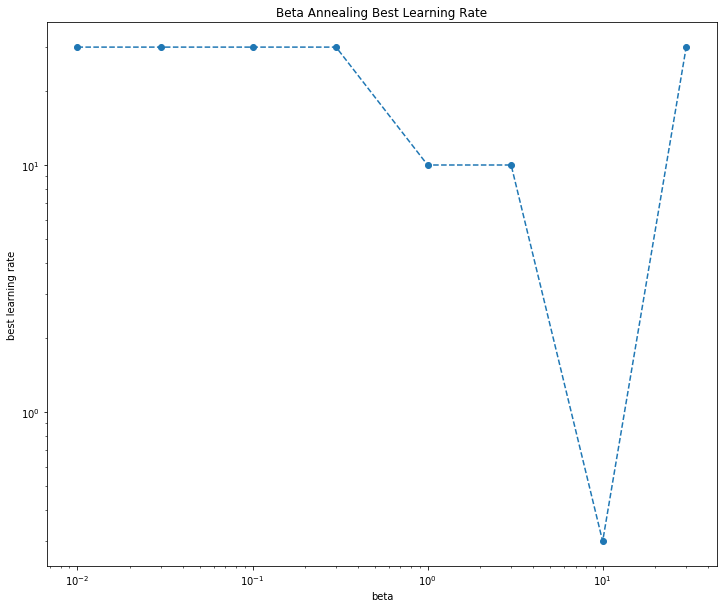

In [304]:
plt.figure(figsize=(12, 10))
plt.plot(beta_lst, all_lr, 'o--')
plt.title("Beta Annealing Best Learning Rate")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("beta")
plt.ylabel("best learning rate")
plt.savefig('../plots/10_15_beta_annealing_best_lr.png')
plt.show()
plt.close()

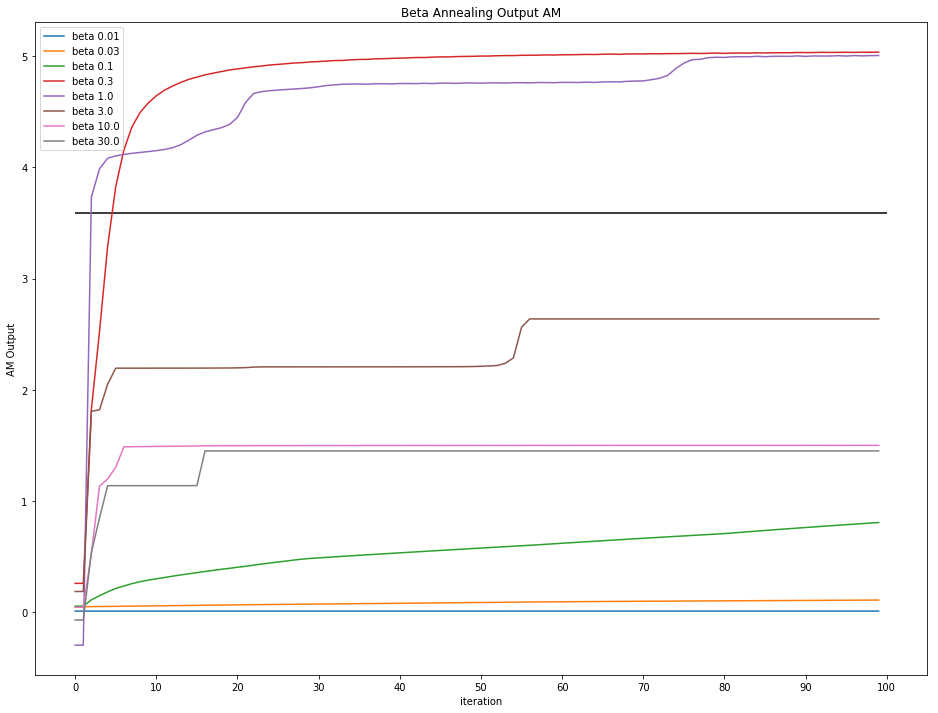

In [297]:
plt.figure(figsize = (16, 12))
for beta, outputs in zip(beta_lst, all_output): 
    plt.plot(outputs, label="beta {}".format(beta))
plt.legend()
plt.title("Beta Annealing Output AM")
plt.xlabel("iteration")
plt.xticks(range(0, 110, 10))
plt.ylabel("AM Output")
plt.savefig('../plots/10_15_beta_annealing_output_am.png')
plt.hlines(max(y), 0, 100, label='y_max', linestyles='solid')
plt.show()
plt.close()

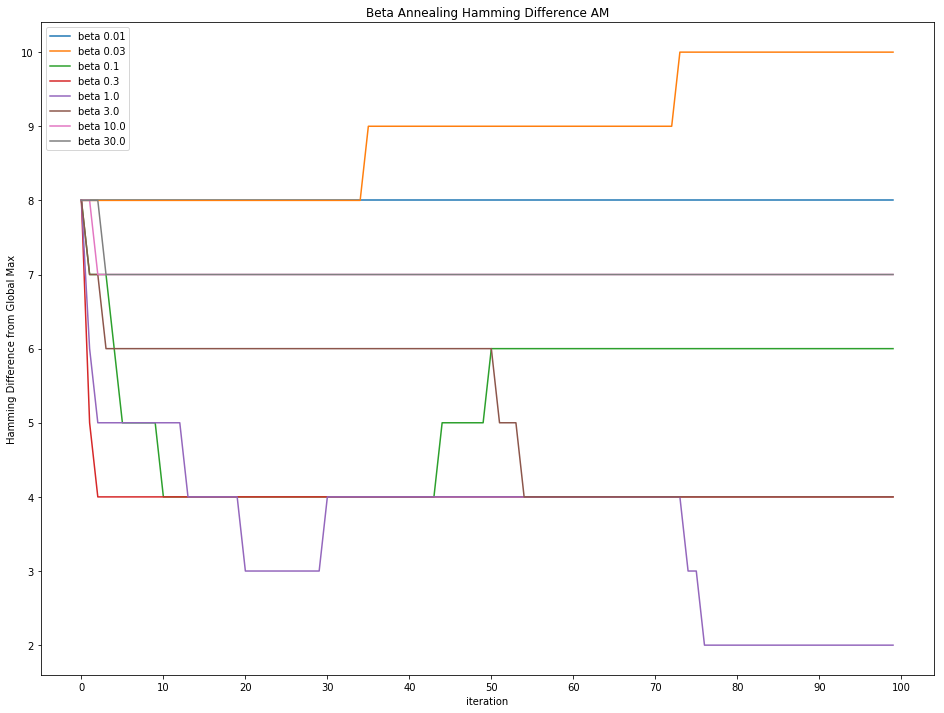

In [298]:
plt.figure(figsize = (16, 12))
for beta, hamming in zip(beta_lst, all_hamming): 
    plt.plot(hamming, label="beta {}".format(beta))
plt.legend()
plt.title("Beta Annealing Hamming Difference AM")
plt.xlabel("iteration")
plt.xticks(range(0, 110, 10))
plt.ylabel("Hamming Difference from Global Max")
plt.savefig('../plots/10_15_beta_annealing_hamming_diff.png')
plt.show()
plt.close()

3.5857574623788016